# **<center><b>Caso Titanic - Random Forest</b></center>**

##<h2><b>1. Preparacion del Modelo</b></h2>

### <center><h2><b>1.1. Montar Titanic Dataset</b></h2></center>

In [233]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### <h2><b>1.2. Importar Librerias Python</b></h2>

In [234]:
# Import Titanic DataSet
from load_titanic_dataset import load_titanic

# Import Sckti-learn ml  Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    r2_score
)
from sklearn.ensemble import RandomForestClassifier

# Import Confussion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Import saving ml model
import joblib

# Import other ml libraries
import numpy as np
import pandas as pd

### <h2><b>1.3. Cargar la data de Titanic</b></h2>

In [235]:
# Load Titanic dataset
print("Loading Titanic dataset...")
dataset = load_titanic('/content/titanic.csv')
X = dataset.data
y = dataset.target
print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

Loading Titanic dataset...
Dataset loaded: 891 samples, 9 features


In [236]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<h2><b>2. Entrenamiento del modelo</b></h2>

### <h2><b>2.1. Divisón entre Test y Training Data</b></h2>

In [237]:
# Split train and test dataset (20% Test and 80% Training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Train set size: 712 samples
Test set size: 179 samples


### <h2><b>2.2. Definir Hyperparametros</b></h2>

In [238]:
# Normalize scalability on each X feature
# scaler = MinMaxScaler(feature_range=(0,1)) # [0, 1]
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', {0:1, 1:2}]
}

### <h2><b>2.3. Realización de Predicciones</b></h2>

In [239]:
# Training Random Forest model
# model = RandomForestClassifier(
#     n_estimators=100,
#     criterion='gini',
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     min_impurity_decrease=0.0,
# )


# model.fit(X_train, y_train)

model = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,  # Test 100 random combinations
    cv=5,        # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

random_search.fit(X_train, y_train)

# Make predictions
print("Making predictions on test set...")

#y_pred = model.predict(X_test)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Convert the likelyhood into binary label (0 o 1)
y_pred = (y_pred > 0.5)

# Evaluation metrics
print("\n" + classification_report(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Making predictions on test set...

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       105
           1       0.87      0.72      0.79        74

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.84      0.84      0.83       179



##<h2><b>3. Grafica de entrenamiento</b></h2>

### <h2><b>3.1. Gráfico Matriz de Confusión</b></h2>

Confusion Matrix:
 [[97  8]
 [21 53]]


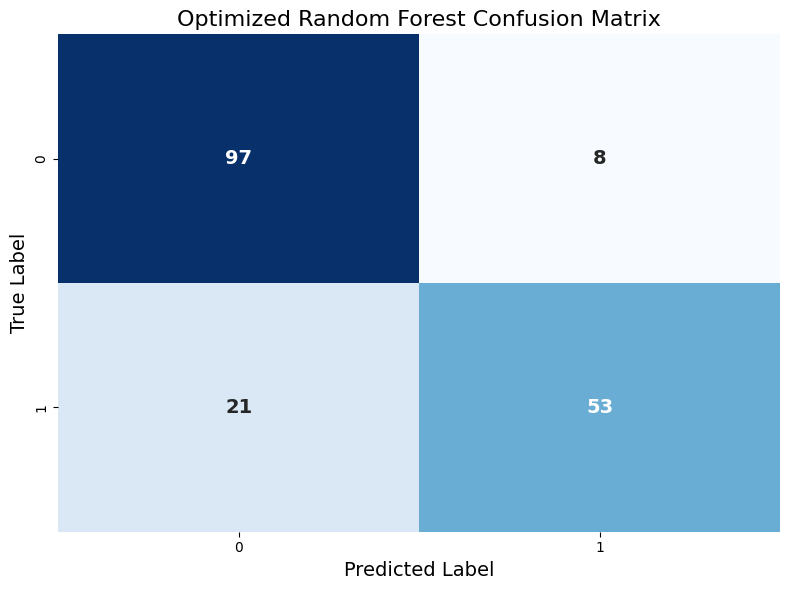

In [240]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Heat Map Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 14, "weight": "bold"})
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Optimized Random Forest Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

### <h2><b>3.2. Gráfico Curva ROC</b></h2>

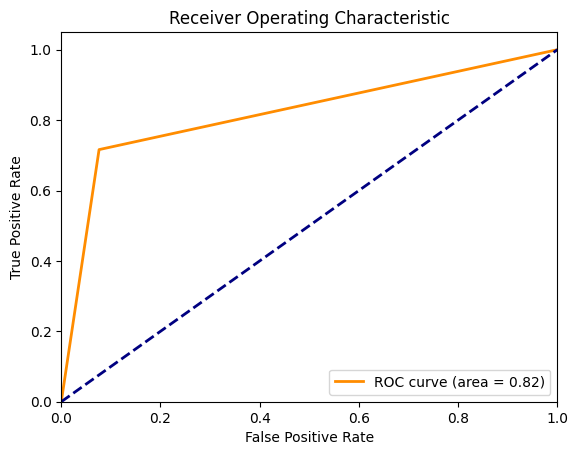

In [241]:
# ROC Curve
auc = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(roc_curve(y_test, y_pred)[0], roc_curve(y_test, y_pred)[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' %auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

##<h2><b>4. Gráfica de Importancia de Atributos</b></h2>

### <h2><b>4.1. Importancia de atributos</b></h2>

In [246]:
# Feature Importance
importances = model.fit(X_train, y_train).feature_importances_
feature_importances = pd.DataFrame({
    'Variable': dataset.feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importances.head(10))


Top 10 Important Features:
     Variable  Importance
3        fare    0.284943
6    sex_male    0.269825
0         age    0.247264
5    pclass_3    0.061052
1       sibsp    0.048883
2       parch    0.036750
8  embarked_S    0.023974
4    pclass_2    0.018209
7  embarked_Q    0.009100


### <h2><b>4.2. Gráfico de Importancia de Atributos</b></h2>

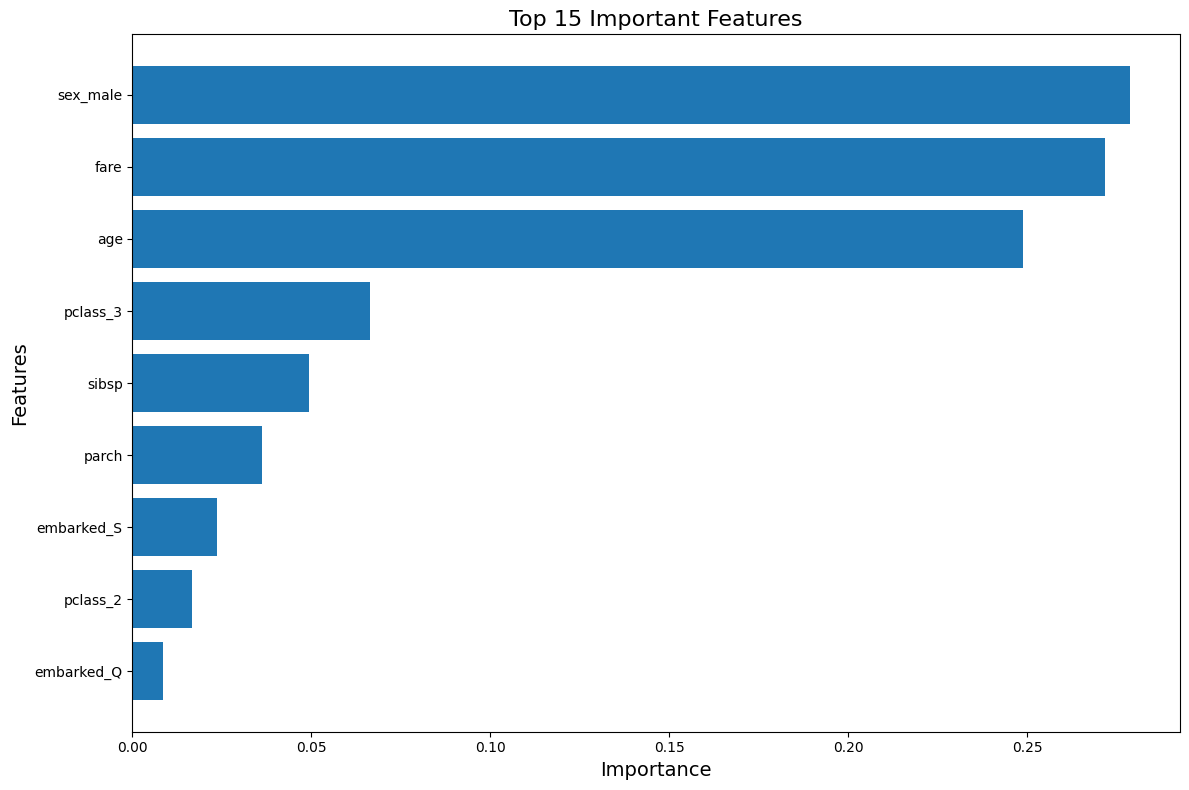

In [243]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Variable'][:15], feature_importances['Importance'][:15])
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 15 Important Features', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## <h2><b>5. Evaluación Métricas</b></h2>

In [244]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall (Sensitivity)": recall_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Specificity": recall_score(y_test, y_pred, pos_label=0),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_pred),
    "R2 Score": r2_score(y_test, y_pred)
}

print("\nOptimized Model Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Optimized Model Metrics:
Accuracy: 0.8380
Recall (Sensitivity): 0.7162
Precision: 0.8689
Specificity: 0.9238
F1 Score: 0.7852
ROC AUC Score: 0.8200
R2 Score: 0.3319


## <h2><b>6. Guardado del modelo entrenado</b></h2>

### <h2><b>6.1. Guardando el Modelo KNN</b></h2>

In [247]:
# Save model
joblib.dump(model, 'random_forest_model.pkl')
print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


### <h2><b>6.2. Validación del Modelo</b></h2>

In [248]:
# Load saved model
loaded_model = joblib.load('random_forest_model.pkl')

# making predictions with loaded model
y_pred = model.predict(X_test)

In [249]:
# Validate loaded model
y_pred_loaded = loaded_model.predict(X_test)
acc_loaded = accuracy_score(y_test, y_pred_loaded)
print(f"Loaded model accuracy: {acc_loaded:.4f} (original: {metrics['Accuracy']:.4f})")

Loaded model accuracy: 0.7989 (original: 0.8380)
